In [1]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np
import scipy
import networkx as nx
import time

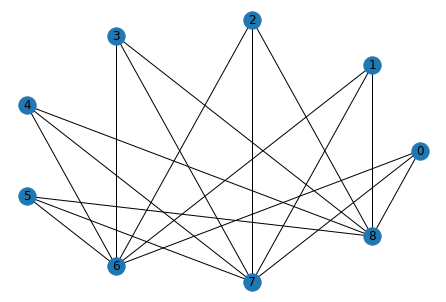

In [2]:
visible_states = [0, 1, 2, 3, 4, 5]
hidden_states = [6, 7, 8]
G = nx.Graph()
G.add_nodes_from(visible_states)
G.add_nodes_from(hidden_states)
G.add_edges_from([(i, j) for i in visible_states for j in hidden_states])
nx.draw_circular(G, with_labels=True)

In [14]:
num_qubits = len(visible_states) + len(hidden_states)

transverse_field_weight = 2.0
single_params = np.array([np.random.uniform(low=-1.0, high=1.0) for _ in range(num_qubits)])
double_params =  {tuple(sorted(edge)): np.random.uniform(low=-1.0, high=1.0) for edge in G.edges}

H = np.zeros((2 ** num_qubits, 2 ** num_qubits))

pauli_z = np.array([[1, 0], [0, -1]])
pauli_x = np.array([[0, 1], [1, 0]])
identity = np.array([[1, 0], [0, 1]])

for i, b in enumerate(single_params):
    m = b
    for j in range(num_qubits):
        if j == i:
            m = np.kron(m, pauli_z)
        else:
            m = np.kron(m, identity)
    H = np.add(H, m)

# note: this double param loop was all generated by github copilot and im kinda scared of AI now
for i, (a, b) in enumerate(G.edges()):
    m = double_params[(a, b)]
    for j in range(num_qubits):
        if j == a or j == b:
            m = np.kron(m, pauli_z)
        else:
            m = np.kron(m, identity)
    H = np.add(H, m)

for i in range(num_qubits):
    m = transverse_field_weight
    for j in range(num_qubits):
        if j == i:
            m = np.kron(m, pauli_x)
        else:
            m = np.kron(m, identity)
    H = np.add(H, m)

In [5]:
from active_coresets.maxcut_vqt import optimize_vqt
from active_coresets.ansatz import ZZansatz

In [6]:
beta = 1

In [7]:
start_time = time.time()
ansatz = ZZansatz(G)
thermal_state = optimize_vqt(H, beta, ansatz)
total_vqt_time = time.time() - start_time

In [4]:
from qiskit.opflow.primitive_ops import PauliSumOp

In [203]:
start_time = time.time()
exp_H = scipy.linalg.expm(-1 * beta * H)
partition_function = np.trace(exp_H)
exact_thermal_state = qiskit.quantum_info.DensityMatrix(exp_H / partition_function)

pauli_str = 'Z' + 'I' * (num_qubits - 1)
expectation_0 = exact_thermal_state.expectation_value(PauliSumOp.from_list([(pauli_str, 1)])).real
print(f'Exact expectation: {expectation_0}')

total_exact_time = time.time() - start_time

Exact expectation: 0.3797867405514621


In [250]:
import importlib
import active_coresets.population_annealing
importlib.reload(active_coresets.population_annealing)

from active_coresets.population_annealing import population_annealing

In [201]:
approx_expectation = population_annealing(transverse_field_weight, single_params, double_params, 10, 64, 0, 5, 0.2, 1000)
print(f'Approx expectation: {approx_expectation}')

Approx expectation: [-0.60625  -0.534375 -0.58125  -0.61875  -0.678125 -0.590625 -0.553125
 -0.640625 -0.528125]


In [202]:
approx_expectation = population_annealing(transverse_field_weight, single_params, double_params, 10, 64, 0, 5, 0.2, 1000)
print(f'Approx expectation: {approx_expectation}')

Approx expectation: [-0.60625  -0.54375  -0.590625 -0.65     -0.65     -0.540625 -0.565625
 -0.596875 -0.5625  ]


In [251]:
approx_expectation, history = population_annealing(transverse_field_weight, single_params, double_params, 10, 64, 0, 5, 0.2, 1000)
print(f'Approx expectation: {approx_expectation}')

/home/jviszlai/Documents/Research/Coresets/Bayesian-inference-coresets/active_coresets/population_annealing.py:30: RuntimeWarning: divide by zero encountered in log
  E_qm += np.log(np.tanh(beta * transverse_field_weight / time_slices))
/home/jviszlai/Documents/Research/Coresets/Bayesian-inference-coresets/active_coresets/population_annealing.py:33: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-beta * (E_cl + E_qm))


Approx expectation: [-0.53125  -0.6875   -0.5875   -0.60625  -0.7      -0.571875 -0.471875
 -0.609375 -0.559375]


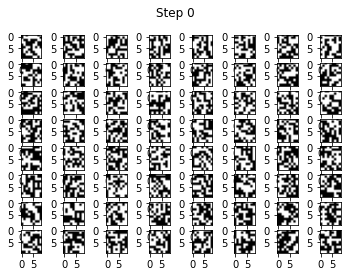

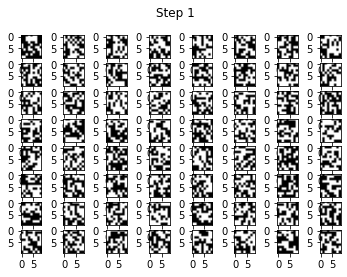

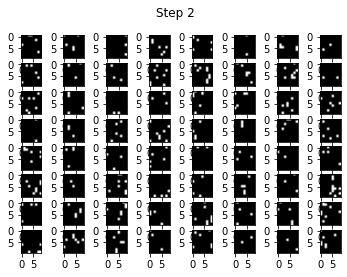

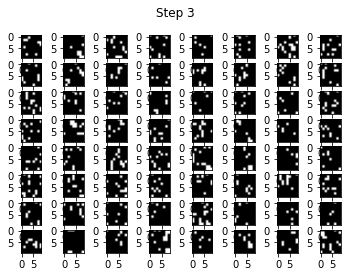

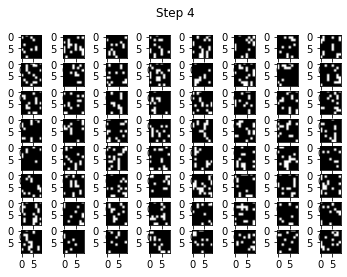

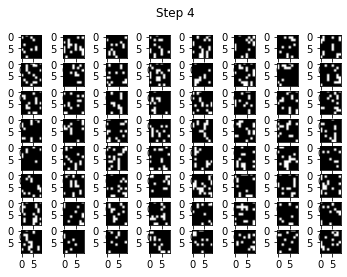

In [252]:
from celluloid import Camera
from IPython.display import display

fig, axs = plt.subplots(8, 8)
camera = Camera(fig)

num_steps = history.shape[0]
num_copies = history.shape[1]
num_units = history.shape[2]

for i in range(num_steps):
    for j in range(num_copies):
        row = j // 8
        axs[row, j - row * 8].imshow(history[i, j], cmap='binary')
        fig.suptitle(f'Step {i}')
    display(fig)
    camera.snap()

anim = camera.animate()
anim.save('animation.gif', writer='imagemagick', fps=1)
